## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time:
* Instructor name: Morgan Jones
* Blog post URL: 


# Business Problem



## The Data



# Setup

### Import relevant packages

In [1]:
import sqlite3 
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load and Clean Data

## Training values set

In [2]:
training_values = pd.read_csv('data/Training_set_values.csv')
print(len(training_values))
training_values.head()

59400


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
training_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Investigate funder, installer, subvillage, public_meeting, scheme management, scheme_name, permit

- funder:
    - 3635 missing values (6.1%)
    - Not Known, Unknown,  categories
    - 0 category
- installer: 
    - 3655 missing values (6.1%)
    - uknown, Unknown, Not known categories
- subvillage:
    - 371 missing values (0.6%)
    - relatively few missing values - drop the offending rows
- public_meeting:
    - 3334 missing values (5.6%)
    - binary true/false
    - drop missing rows - want to keep it binary
- scheme management:
    - 3877 missing values (6.5%)
    - will likeley create an "unknown" column
    - one occurance of None - remove (unable to have an example in both test and training sets)
- scheme name:
    - 28166 missing values (47.4%)
    - too much missing data - drop this 
- permit:
    - 3056 missing values (5.1%)
    - binary true/false
    - drop missing rows - want to keep it binary
    
After cleaning, 52,911 data points (89% of original set)

In [4]:
## clean up subvillage, permit, and public_meeting columns
# remove Nan values
training_values = training_values.dropna(axis=0, subset=['permit', 'public_meeting'])

In [5]:
## drop scheme_name, wpt_name, longitude, latitude column
drop_cols = ['scheme_name', 'wpt_name', 'longitude', 'latitude', 'date_recorded', 'subvillage', 'ward']
training_values = training_values.drop(columns=drop_cols, axis=1)

In [6]:
## clean up funder column
# combine Not Known, Unknown, and Nan categories into one 'Unknown'
training_values['funder'] = training_values['funder'].fillna('Unknown')
training_values['funder'] = training_values['funder'].map(lambda x: 'Unknown' if 'Not Known' in x else x)

# create an "other" column for all funders with less than 10 wells
small_funders = []
for key, value in training_values['funder'].value_counts().to_dict().items():
    if value < 16:
        small_funders.append(key)
        
training_values['funder'] = training_values['funder'].map(lambda x: 'Other' if x in small_funders else x)

In [7]:
## clean up installer column
# combine uknown, Unknown, Not known, and Nan categories into one 'Unknown'
training_values['installer'] = training_values['installer'].fillna('Unknown')
training_values['installer'] = training_values['installer'].map(lambda x: 'Unknown' if 'Not known' in x else x)
training_values['installer'] = training_values['installer'].map(lambda x: 'Unknown' if 'unknown' in x else x)

# create an "other" column for all installers with less than 10 wells
small_installers = []
for key, value in training_values['installer'].value_counts().to_dict().items():
    if value < 15:
        small_installers.append(key)
        
training_values['installer'] = training_values['installer'].map(lambda x: 'Other' if x in small_installers else x)

In [8]:
## clean up scheme_management column
# convert Nan values into one 'Unknown'
training_values['scheme_management'] = training_values['scheme_management'].fillna('Unknown')

# remove one row with "None"
training_values = training_values[training_values['scheme_management'] != 'None']

In [9]:
training_values = training_values[training_values['extraction_type'] != 'other - mkulima/shinyanga']
training_values['extraction_type'].value_counts()

gravity              24339
nira/tanira           7265
other                 5641
submersible           3971
swn 80                3491
mono                  2516
india mark ii         2261
afridev               1530
ksb                   1334
other - rope pump      278
other - swn 81         208
windmill               104
cemo                    90
india mark iii          88
other - play pump       84
walimi                  46
climax                  32
Name: extraction_type, dtype: int64

In [10]:
# remove one row with "Nyamagana"
training_values = training_values[training_values['lga'] != 'Nyamagana']
training_values['lga'].value_counts()

Njombe           2500
Moshi Rural      1228
Arusha Rural     1197
Kilosa           1070
Kasulu           1045
                 ... 
Kigoma Urban       69
Serengeti          53
Ilala              36
Lindi Urban        21
Singida Rural      17
Name: lga, Length: 121, dtype: int64

In [11]:
for col in list(training_values.columns):
    print(f'{col}: {len(training_values[col].value_counts())}')
# not dummy variables
# id, gps_height, population, construction_year

id: 53277
amount_tsh: 91
funder: 302
gps_height: 2426
installer: 304
num_private: 61
basin: 9
region: 21
region_code: 27
district_code: 20
lga: 121
population: 1006
public_meeting: 2
recorded_by: 1
scheme_management: 12
permit: 2
construction_year: 55
extraction_type: 17
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6


## Training Set Labels

restrict the training set labels to only contain ids that are included in the cleaned training values dataset

In [12]:
training_labels = pd.read_csv('data/Training_set_labels.csv')
training_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [13]:
mask = training_labels['id'].isin(list(training_values.id))
training_labels = training_labels[mask]
print(len(training_values))

53277


# Data Prep
prep data to be used in a classification problem

## Split the given training set into a train set and a test set

In [14]:
X = training_values.drop(columns=['id'], axis=1)
y = training_labels['status_group']

In [15]:
SEED = 42

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

## Encode categorical data as numbers

In [17]:
# identify the non categorical columns that will not be included in the one hot encoding
non_categorical_cols = ['amount_tsh', 'gps_height', 'population', 'construction_year', 'num_private', 'region_code']

In [18]:
# initialize the One Hot Encoder
ohe = OneHotEncoder()

In [19]:
def encode_X(X, non_categorical_cols):
    categorical_df = X.drop(columns=non_categorical_cols, axis=1)
    non_categorical_df = X[non_categorical_cols]

    X_ohe_categorical = ohe.fit_transform(categorical_df).toarray()
    ohe_df = pd.DataFrame(X_ohe_categorical, columns=ohe.get_feature_names(categorical_df.columns))

    X_ohe = pd.concat([ohe_df, non_categorical_df], axis=1)

    ohe_df['ind'] = categorical_df.index
    ohe_df = ohe_df.set_index('ind')
    ohe_df.head()

    X_ohe_final = pd.concat([ohe_df, non_categorical_df], axis=1)
    
    print(len(X_ohe_final.columns))
    
    return X_ohe_final

X_train_ohe = encode_X(X_train, non_categorical_cols)
X_test_ohe = encode_X(X_test, non_categorical_cols)

925
925


# Functions for Evaluating Model Performance

In [48]:
# function to perform one hot encoding on the y results
def create_y_ohe(y, columns):
    ohe = OneHotEncoder()
    y_df = pd.DataFrame(y, columns=columns)
    y_ohe = ohe.fit_transform(y_df).toarray()
    y_ohe_df = pd.DataFrame(y_ohe, columns=ohe.get_feature_names(y_df.columns))
    return y_ohe_df

    
# functional subset accuracy
def performance_metrics(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall, 
        'auc': roc_auc
    }
    
    return results


def evaluate_sbuset_performance(y_test_ohe_df, y_pred_ohe_df):
    subsets = ['status_group_functional', 'status_group_functional needs repair', 'status_group_non functional']
    
    final_results = {}
    
    for subset in subsets:
        y_pred = y_pred_ohe_df[subset]
        y_test = y_test_ohe_df[subset]
        
        results = performance_metrics(y_test, y_pred)
        final_results[subset] = results
    
    return final_results
        

def evaluate_model_performance(y_test, y_pred):
    y_test_ohe_df = create_y_ohe(y_test, columns=['status_group'])
    y_pred_ohe_df = create_y_ohe(y_pred, columns=['status_group'])
    
    subset_results = evaluate_sbuset_performance(y_test_ohe_df, y_pred_ohe_df)
    
    accuracy = []
    precision = []
    recall = []
    auc = []
    for subset in subset_results.keys():
        accuracy.append(subset_results[subset]['accuracy'])
        precision.append(subset_results[subset]['precision'])
        recall.append(subset_results[subset]['recall'])
        auc.append(subset_results[subset]['auc'])
    
    avg_accuracy = np.array(accuracy).mean()
    avg_precision = np.array(precision).mean()
    avg_recall = np.array(recall).mean()
    avg_auc = np.array(auc).mean()
    
    results = {
        'accuracy': avg_accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'auc': avg_auc
    }
    
    return results

# Base Model

## Train the tree

In [22]:
clf_base = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
clf_base.fit(X_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

## Fit the Tree

In [23]:
y_pred_base = clf_base.predict(X_test_ohe)

In [24]:
X_test_ohe.head()

,funder_0,funder_Aar,funder_Abasia,funder_Acra,funder_Adb,funder_Adp,funder_Adra,funder_African,funder_African Development Bank,funder_Aict,...,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,amount_tsh,gps_height,population,construction_year,num_private,region_code
37787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50.0,986,1200,2009,0,2
601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,873,368,2000,0,13
3994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,0,0,0,17
54323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1000.0,1425,329,1986,0,13
51017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,17


## Evaluate the performance

In [49]:
results = evaluate_model_performance(y_test.values, y_pred_base)

print(f'Model 1 Performance')
print(f'  accuracy = {results["accuracy"]}')
print(f'  precision = {results["precision"]}')
print(f'  recall = {results["recall"]}')
print(f'  auc = {results["auc"]}')

Model 1 Performance
  accuracy = 0.8381297964631297
  precision = 0.652273865684135
  recall = 0.6458765489972248
  auc = 0.749844999538722


We have an accuracy of 84% with no model tailoring - what about over fitting

# Hyperparemeter Tuning

### Function to perform the tuning

In [158]:
def investigate_parameter(param_name, param_values, max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features=None):
    
    train_auc = []
    test_auc = []
    
    train_accuracy = []
    test_accuracy = []
    
    train_precision = []
    test_precision = []

    for value in param_values:
        
#         print(value)
        
        if param_name == 'max_depth': 
            dt = DecisionTreeClassifier(criterion='entropy', 
                                        max_depth=value,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        max_features=max_features,
                                        random_state=SEED)
        elif param_name == 'min_samples_leaf':
            dt = DecisionTreeClassifier(criterion='entropy',  
                                        max_depth=max_depth,
                                        min_samples_leaf=value,
                                        min_samples_split=min_samples_split,
                                        max_features=max_features,
                                        random_state=SEED)
        elif param_name == 'min_samples_split':
            dt = DecisionTreeClassifier(criterion='entropy', 
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=value,
                                        max_features=max_features,
                                        random_state=SEED)
        elif param_name == 'max_features':
            dt = DecisionTreeClassifier(criterion='entropy', 
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        max_features=value, 
                                        random_state=SEED)
        
        dt.fit(X_train_ohe, y_train)

        train_pred = dt.predict(X_train_ohe)
        test_pred = dt.predict(X_test_ohe)

        test_performance = evaluate_model_performance(y_test, test_pred)
        train_performance = evaluate_model_performance(y_train, train_pred)

        train_auc.append(train_performance['auc'])
        test_auc.append(test_performance['auc'])
        
        train_precision.append(train_performance['precision'])
        test_precision.append(test_performance['precision'])
        
        train_accuracy.append(train_performance['accuracy'])
        test_accuracy.append(test_performance['accuracy'])

    plt.figure(figsize=(15, 8))
    plt.plot(param_values, train_auc, label='train auc')
    plt.plot(param_values, test_auc, label='test auc')
    plt.grid()
    plt.xlabel(param_name)
    plt.ylabel('auc')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15, 8))
    plt.plot(param_values, test_precision, label='test precision')
    plt.plot(param_values, test_accuracy, label='test accuracy')
    plt.grid()
    plt.xlabel(param_name)
    plt.ylabel('auc')
    plt.legend()
    plt.show()
    

## Max Depth

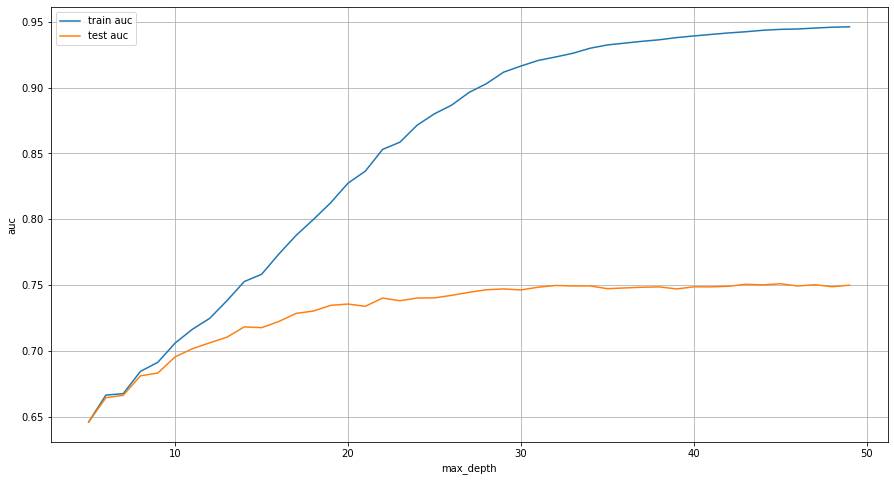

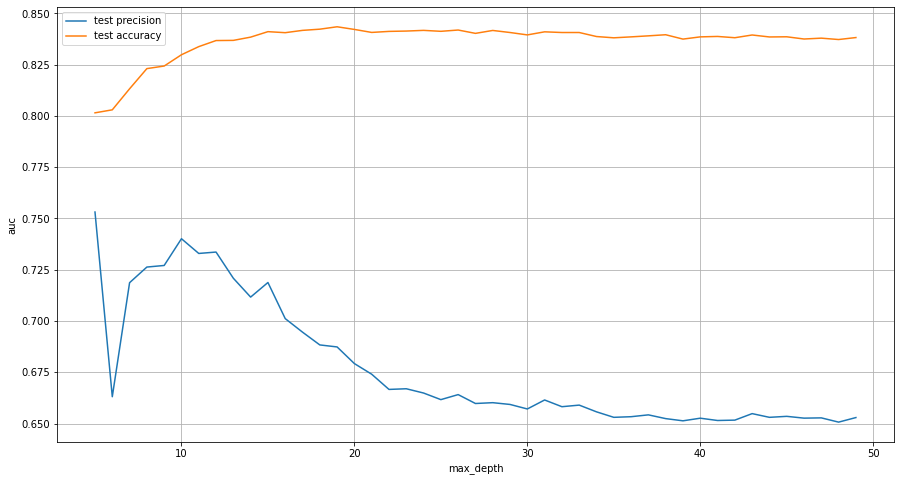

In [159]:
max_depths = list(range(5,50))
investigate_parameter(param_name='max_depth', param_values=max_depths)    

### Results
the test results auc flattens out around 30, but the max occurs at 43

In [152]:
selected_max_depth = 43

In [153]:
clf2 = DecisionTreeClassifier(criterion='entropy', 
                             max_depth=selected_max_depth,
                             random_state=SEED)
clf2.fit(X_train_ohe, y_train)
y_pred_2 = clf2.predict(X_test_ohe)

In [154]:
results2 = evaluate_model_performance(y_test.values, y_pred_2)

print(f'Model 1 Performance')
print(f'  accuracy = {results2["accuracy"]}')
print(f'  precision = {results2["precision"]}')
print(f'  recall = {results2["recall"]}')
print(f'  auc = {results2["auc"]}')

Model 1 Performance
  accuracy = 0.8394644644644645
  precision = 0.6548271301584208
  recall = 0.646794431959394
  auc = 0.7505784866032298


## Min Samples Leaf

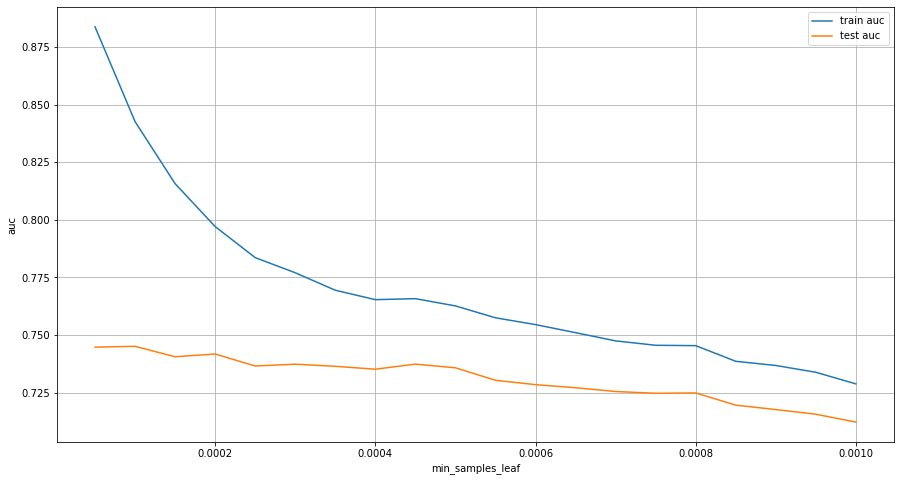

In [155]:
min_samples_leaf = np.linspace(0.00005, 0.001, 20, endpoint=True)
investigate_parameter(param_name='min_samples_leaf', param_values=min_samples_leaf, max_depth=selected_max_depth)  

## Max Features

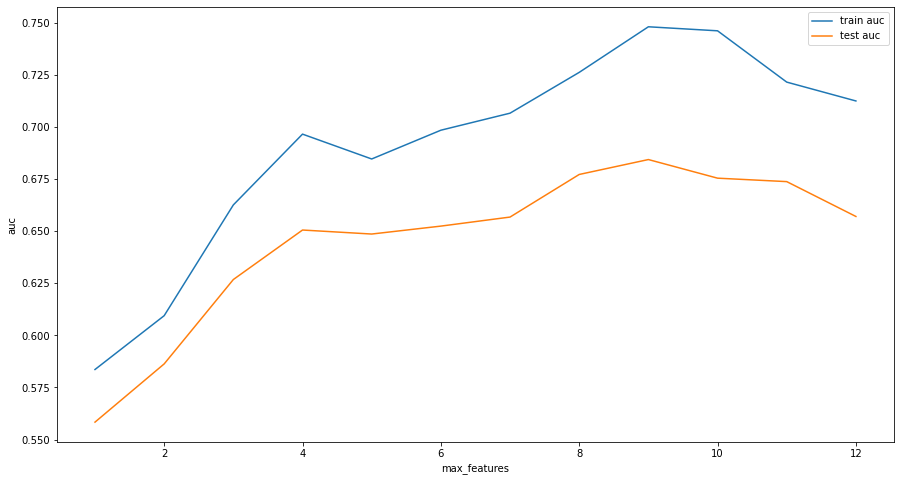

In [131]:
max_features = list(range(1, 13))
investigate_parameter(param_name='max_features', param_values=max_features, max_depth=selected_max_depth)  

### Results
AUC peaks at 9

In [132]:
selected_max_features = 9

# Final Model

In [136]:
clf2 = DecisionTreeClassifier(criterion='entropy', 
                             max_depth=selected_max_depth,
                             max_features=selected_max_features,
                             random_state=SEED)
clf2.fit(X_train_ohe_final, y_train)
y_pred_2 = clf2.predict(X_test_ohe_final)

In [137]:
results = evaluate_model_performance(y_test, y_pred_2)

print(f'Model 1 Performance')
print(f'  accuracy = {results["accuracy"]}')
print(f'  precision = {results["precision"]}')
print(f'  recall = {results["recall"]}')
print(f'  auc = {results["auc"]}')

Model 1 Performance
  accuracy = 0.809079837050103
  precision = 0.6345454634508579
  recall = 0.5551147201983635
  auc = 0.684356007330336
